# Importing Libraries

In [1]:
from google.colab import drive
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
from rasterio import features
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import folium
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Process Data

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Batas Wilayah Kecamatan

batas_kec = gpd.read_file("/content/drive/MyDrive/Dataset/SIG/Batas/batas_kecamatan_bengkulu.shp")
# Filter data untuk mengambil data kota bengkulu saja
batas_kec_bengkulu = batas_kec[batas_kec['WADMKK'] == 'BENGKULU']

print(batas_kec_bengkulu.head(9))
print(batas_kec_bengkulu.info())

   KDPPUM            NAMOBJ                          REMARK KDPBPS FCODE  \
0    None     KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None   
2    None     GADINGCEMPAKA  Wilayah Administrasi Kecamatan   None  None   
3    None           SELEBAR  Wilayah Administrasi Kecamatan   None  None   
4    None      SINGARANPATI  Wilayah Administrasi Kecamatan   None  None   
5    None        RATUSAMBAN  Wilayah Administrasi Kecamatan   None  None   
6    None         RATUAGUNG  Wilayah Administrasi Kecamatan   None  None   
7    None       TELUKSEGARA  Wilayah Administrasi Kecamatan   None  None   
9    None       SUNGAISERUT  Wilayah Administrasi Kecamatan   None  None   
10   None  MUARABANGKA HULU  Wilayah Administrasi Kecamatan   None  None   

    LUASWH  UUPP SRS_ID   LCODE METADATA  ... WADMKC WIADKC    WADMKK WIADKK  \
0      0.0  None   None  BA0080     None  ...   None   None  BENGKULU   None   
2      0.0  None   None  BA0080     None  ...   None   None  BENGKULU   None   

In [3]:
# Visualisasi Batas Kecamatan
m = folium.Map(location=[-3.858, 102.3], zoom_start=12)
folium.GeoJson(
    batas_kec_bengkulu,
    tooltip=folium.features.GeoJsonTooltip(fields=['NAMOBJ'])
).add_to(m)
display(m)

In [4]:
# Tutupan Lahan
tuplah = gpd.read_file("/content/drive/MyDrive/Dataset/SIG/Tuplah/Tuplah_Bengkulu_2019.shp")
batas_kec_tuplah = gpd.sjoin(batas_kec_bengkulu, tuplah[['Legenda', 'geometry']], how="left", predicate='intersects')
print(batas_kec_tuplah.head())

  KDPPUM         NAMOBJ                          REMARK KDPBPS FCODE  LUASWH  \
0   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   
0   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   
0   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   
0   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   
0   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   

   UUPP SRS_ID   LCODE METADATA  ...    WADMKK WIADKK    WADMPR WIADPR TIPADM  \
0  None   None  BA0080     None  ...  BENGKULU   None  BENGKULU   None      0   
0  None   None  BA0080     None  ...  BENGKULU   None  BENGKULU   None      0   
0  None   None  BA0080     None  ...  BENGKULU   None  BENGKULU   None      0   
0  None   None  BA0080     None  ...  BENGKULU   None  BENGKULU   None      0   
0  None   None  BA0080     None  ...  BENGKULU   None  BENGKULU   None      0   

  Shape_Leng Shape_Area         

In [6]:
# Kelas Kemiringan Lereng
lereng = gpd.read_file("/content/drive/MyDrive/Dataset/SIG/Lereng/Kelas_Lereng_Bengkulu.shp")

if 'index_right' in batas_kec_tuplah.columns:
    batas_kec_tuplah = batas_kec_tuplah.drop(columns=['index_right'])

batas_kec_lereng = gpd.sjoin(batas_kec_tuplah, lereng[['kemiringan', 'geometry']], how="left", predicate='intersects')
print(batas_kec_lereng.head())

  KDPPUM         NAMOBJ                          REMARK KDPBPS FCODE  LUASWH  \
0   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   
0   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   
0   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   
0   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   
0   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   

   UUPP SRS_ID   LCODE METADATA  ... WIADKK    WADMPR WIADPR TIPADM  \
0  None   None  BA0080     None  ...   None  BENGKULU   None      0   
0  None   None  BA0080     None  ...   None  BENGKULU   None      0   
0  None   None  BA0080     None  ...   None  BENGKULU   None      0   
0  None   None  BA0080     None  ...   None  BENGKULU   None      0   
0  None   None  BA0080     None  ...   None  BENGKULU   None      0   

  Shape_Leng Shape_Area                                           geometry  \
0   0.583022  

In [7]:
# Rata-Rata Elevasi
dem_path = "/content/drive/MyDrive/Dataset/SIG/DEM/DEM.tif"
def extract_dem_mean(gdf, dem_path):
    with rasterio.open(dem_path) as src:
        means = []
        for geom in gdf.geometry:
            mask = features.geometry_mask([geom], transform=src.transform, invert=True, out_shape=src.shape)
            data = src.read(1, masked=True)
            masked_data = np.ma.masked_array(data, mask=~mask)
            means.append(masked_data.mean())
        return means

batas_kec_lereng["rata-rata_elevasi"] = extract_dem_mean(batas_kec_lereng, dem_path)
print(batas_kec_lereng.head())

  KDPPUM         NAMOBJ                          REMARK KDPBPS FCODE  LUASWH  \
0   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   
0   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   
0   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   
0   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   
0   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   

   UUPP SRS_ID   LCODE METADATA  ...    WADMPR WIADPR TIPADM Shape_Leng  \
0  None   None  BA0080     None  ...  BENGKULU   None      0   0.583022   
0  None   None  BA0080     None  ...  BENGKULU   None      0   0.583022   
0  None   None  BA0080     None  ...  BENGKULU   None      0   0.583022   
0  None   None  BA0080     None  ...  BENGKULU   None      0   0.583022   
0  None   None  BA0080     None  ...  BENGKULU   None      0   0.583022   

  Shape_Area                                           geometry     

In [8]:
curah_hujan = pd.read_csv("/content/drive/MyDrive/Dataset/SIG/CurJan/curah_hujan.csv")
curah_hujan = curah_hujan.rename(columns={'Jumlah Curah Hujan di Stasiun Klimatologi Bengkulu (mm)': 'CurahHujan'})

# Gunakan key gabungan sementara untuk menggabungkan kedua DataFrame
batas_kec_lereng['key'] = 1
curah_hujan['key'] = 1
batas_kec_curah_hujan = pd.merge(batas_kec_lereng, curah_hujan, on='key').drop('key', axis=1)
batas_kec_lereng = batas_kec_lereng.drop('key', axis=1)
curah_hujan = curah_hujan.drop('key', axis=1)

print(batas_kec_curah_hujan.head())

  KDPPUM         NAMOBJ                          REMARK KDPBPS FCODE  LUASWH  \
0   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   
1   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   
2   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   
3   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   
4   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   

   UUPP SRS_ID   LCODE METADATA  ... Shape_Leng Shape_Area  \
0  None   None  BA0080     None  ...   0.583022   0.004011   
1  None   None  BA0080     None  ...   0.583022   0.004011   
2  None   None  BA0080     None  ...   0.583022   0.004011   
3  None   None  BA0080     None  ...   0.583022   0.004011   
4  None   None  BA0080     None  ...   0.583022   0.004011   

                                            geometry     Legenda index_right  \
0  POLYGON Z ((102.33978 -3.87873 0, 102.33866 -3...  Perkebunan  

In [9]:
# Buat daftar kecamatan yang rawan banjir
kecamatan_rawan_banjir = ['KAMPUNGMELAYU', 'SELEBAR', 'SINGARANPATI', 'RATUAGUNG', 'MUARABANGKA HULU']

# Tambahkan kolom 'rawan_banjir' ke GeoDataFrame
batas_kec_curah_hujan['rawan_banjir'] = 0 # Inisialisasi semua kecamatan tidak rawan banjir
batas_kec_curah_hujan.loc[batas_kec_curah_hujan['NAMOBJ'].isin(kecamatan_rawan_banjir), 'rawan_banjir'] = 1

print(batas_kec_curah_hujan.head())

  KDPPUM         NAMOBJ                          REMARK KDPBPS FCODE  LUASWH  \
0   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   
1   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   
2   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   
3   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   
4   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   

   UUPP SRS_ID   LCODE METADATA  ... Shape_Area  \
0  None   None  BA0080     None  ...   0.004011   
1  None   None  BA0080     None  ...   0.004011   
2  None   None  BA0080     None  ...   0.004011   
3  None   None  BA0080     None  ...   0.004011   
4  None   None  BA0080     None  ...   0.004011   

                                            geometry     Legenda index_right  \
0  POLYGON Z ((102.33978 -3.87873 0, 102.33866 -3...  Perkebunan           8   
1  POLYGON Z ((102.33978 -3.87873 0, 102.33866 -3...

In [22]:
# Finalisasi Data
dataset = batas_kec_curah_hujan
dataset = dataset.rename(columns={'Legenda': 'Tuplah'})
dataset = dataset.rename(columns={'NAMOBJ': 'Kecamatan'})
dataset['Tuplah_n'], unique_tuplah = pd.factorize(dataset['Tuplah'])
dataset['kemiringan_n'], unique_kemiringan = pd.factorize(dataset['kemiringan'])
dataset['geometry'] = dataset.geometry.make_valid()

print(dataset.head())
print(dataset.info())

Number of invalid geometries before cleaning: 0
Number of invalid geometries after cleaning: 0
  KDPPUM      Kecamatan                          REMARK KDPBPS FCODE  LUASWH  \
0   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   
1   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   
2   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   
3   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   
4   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   

   UUPP SRS_ID   LCODE METADATA  ...      Tuplah index_right kemiringan  \
0  None   None  BA0080     None  ...  Perkebunan           8     15-25%   
1  None   None  BA0080     None  ...  Perkebunan           8     15-25%   
2  None   None  BA0080     None  ...  Perkebunan           8     15-25%   
3  None   None  BA0080     None  ...  Perkebunan           8     15-25%   
4  None   None  BA0080     None  ...  Perkebunan 

# Train & Evaluate Model

In [11]:
# Data Setup & Split
fitur = ["Tuplah_n", "kemiringan_n","rata-rata_elevasi","CurahHujan"]
X = dataset[fitur]
y = dataset["rawan_banjir"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Data Training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

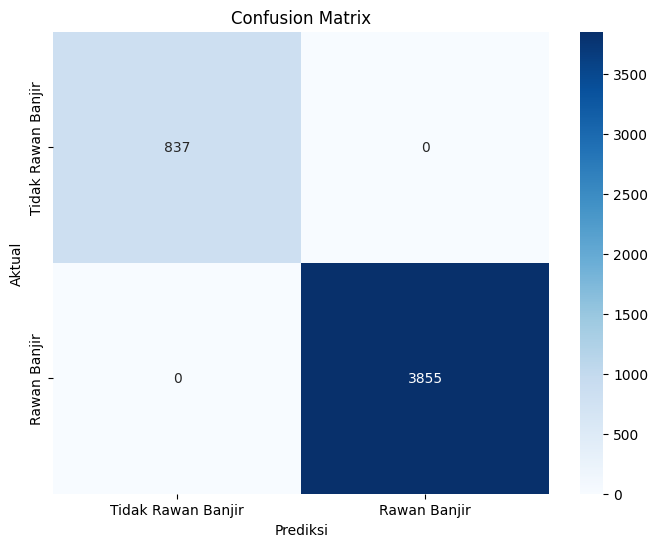

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       837
           1       1.00      1.00      1.00      3855

    accuracy                           1.00      4692
   macro avg       1.00      1.00      1.00      4692
weighted avg       1.00      1.00      1.00      4692



In [13]:
# Evaluasi
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Tidak Rawan Banjir', 'Rawan Banjir'], yticklabels=['Tidak Rawan Banjir', 'Rawan Banjir'])
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(y_test, y_pred))

In [24]:
dataset["prediksi_banjir"] = model.predict(X)
print(dataset.head())

  KDPPUM      Kecamatan                          REMARK KDPBPS FCODE  LUASWH  \
0   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   
1   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   
2   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   
3   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   
4   None  KAMPUNGMELAYU  Wilayah Administrasi Kecamatan   None  None     0.0   

   UUPP SRS_ID   LCODE METADATA  ... index_right kemiringan rata-rata_elevasi  \
0  None   None  BA0080     None  ...           8     15-25%          6.133938   
1  None   None  BA0080     None  ...           8     15-25%          6.133938   
2  None   None  BA0080     None  ...           8     15-25%          6.133938   
3  None   None  BA0080     None  ...           8     15-25%          6.133938   
4  None   None  BA0080     None  ...           8     15-25%          6.133938   

  Tahun     Bulan CurahHujan raw

# RainZone Map

In [35]:
viewmap = batas_kec_bengkulu.merge(dataset[['Kecamatan', 'prediksi_banjir']], left_on='NAMOBJ', right_on='Kecamatan', how='left')
viewmap = viewmap.drop(columns=['NAMOBJ'])
viewmap = viewmap.drop_duplicates(subset=['Kecamatan'])

print(viewmap.head(9))

      KDPPUM                          REMARK KDPBPS FCODE  LUASWH  UUPP  \
0       None  Wilayah Administrasi Kecamatan   None  None     0.0  None   
6120    None  Wilayah Administrasi Kecamatan   None  None     0.0  None   
7560    None  Wilayah Administrasi Kecamatan   None  None     0.0  None   
13500   None  Wilayah Administrasi Kecamatan   None  None     0.0  None   
15300   None  Wilayah Administrasi Kecamatan   None  None     0.0  None   
15600   None  Wilayah Administrasi Kecamatan   None  None     0.0  None   
16500   None  Wilayah Administrasi Kecamatan   None  None     0.0  None   
16800   None  Wilayah Administrasi Kecamatan   None  None     0.0  None   
18960   None  Wilayah Administrasi Kecamatan   None  None     0.0  None   

      SRS_ID   LCODE METADATA KDEBPS  ...    WADMKK WIADKK    WADMPR WIADPR  \
0       None  BA0080     None   None  ...  BENGKULU   None  BENGKULU   None   
6120    None  BA0080     None   None  ...  BENGKULU   None  BENGKULU   None   
7560    None

In [40]:
# Visualisasi Peta Rawan Banjir
def style_function(feature):
    return {
        'fillColor': '#ff0000' if feature['properties']['prediksi_banjir'] == 1 else '#0000ff',
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.5
    }

map = folium.Map(location=[-3.858, 102.3], zoom_start=12)
folium.GeoJson(
    viewmap,
    style_function=style_function,
    tooltip=folium.features.GeoJsonTooltip(fields=['Kecamatan', 'prediksi_banjir'],
        aliases=['Kecamatan:', 'Prediksi Rawan Banjir (1=Rawan, 0=Tidak):'])
).add_to(map)

display(map)

map.save("peta_prediksi_banjir.html")